In [30]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
# For Prediction:
from sklearn.model_selection import train_test_split
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler

# For nice Plots
%matplotlib inline
plt.style.use('default')

# Read in Data

In [31]:
dir_path = os.path.abspath("")
fname = dir_path+'\countrydf.csv'
countrydf = pd.read_csv(fname, encoding='latin-1')
countrydf = countrydf.drop(["Country", "Year"],axis=1)

# Prediction:

In [32]:
# Build a test set and training set

cols_to_standardize = countrydf.columns.drop(['Future Undernourishment'])
scaler = StandardScaler()
countrydf[cols_to_standardize] = scaler.fit_transform(countrydf[cols_to_standardize])

# Print the standardized dataframe
print(countrydf)

X_train, X_test, y_train, y_test = train_test_split(
  countrydf.drop(["Future Undernourishment"], axis=1), countrydf["Future Undernourishment"], test_size=1/3, random_state = 42)

# Replace all the NaNs with the column mean, 
# and build the test set and training set using the indicies from the first set
countrydf2 = countrydf.fillna(countrydf.mean())
# Build a test set and training set
X_train2 = countrydf2.drop(["Future Undernourishment"], axis=1).iloc[X_train.index]
X_test2 = countrydf2.drop(["Future Undernourishment"], axis=1).iloc[X_test.index]
y_train2 = countrydf2["Future Undernourishment"].iloc[y_train.index]
y_test2 = countrydf2["Future Undernourishment"].iloc[y_test.index]

# Use only rows with non-NaN response variable, then replace all the NaNs with the column mean 
# and build the test set and training set using the indicies from the first set
keep_indices_test = np.where(y_test.notna())
keep_indices_train = np.where(y_train.notna())
# Build a test set and training set
X_train3 = X_train2.iloc[keep_indices_train]
X_test3 = X_test2.iloc[keep_indices_test]
y_train3 = y_train2.iloc[keep_indices_train]
y_test3 = y_test2.iloc[keep_indices_test]

      Unnamed: 0   level_0     index  \
0      -1.730448 -1.735120 -1.732732   
1      -1.727240 -1.731986 -1.729883   
2      -1.724033 -1.728851 -1.727033   
3      -1.720825 -1.725717 -1.724184   
4      -1.717618 -1.722583 -1.721334   
...          ...       ...       ...   
1075    1.717618  1.697043  1.695225   
1076    1.720825  1.700177  1.698074   
1077    1.724033  1.703312  1.700924   
1078    1.727240  1.706446  1.703773   
1079    1.730448  1.709581  1.712322   

      Average dietary energy supply adequacy (percent) (3-year average)  \
0                                              1.031639                   
1                                              1.169786                   
2                                              1.238859                   
3                                              1.238859                   
4                                              1.307932                   
...                                                 ...              

# ANN Plot

In [33]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

# ANN for Model 2

In [34]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.optimizers import Adam

def build_model2(n_hidden=1, n_neurons=60, learning_rate=1e-3, input_shape=X_train2.shape[1]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [35]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model2)

C:\Users\stvp2\AppData\Local\Temp\ipykernel_2940\3141062689.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model2)


In [36]:

tf.random.set_seed(42)
# define the input shape and number of classes
input_shape = X_train2.shape[1]
num_classes = 1

# define the model architecture
model = keras.Sequential()
model.add(layers.Dense(70, activation='relu', input_shape=(input_shape,)))
for i in range(3):
    model.add(layers.Dense(70, activation='relu'))
model.add(layers.Dense(num_classes, activation='linear'))

optimizer = Adam(learning_rate=0.001)
# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)
#print(model.summary())
print(input_shape)

# train the model
history2 = model.fit(X_train2, y_train2, epochs=160, validation_data=(X_test2, y_test2))

69
Epoch 1/160
23/23 [==============================] - 0s 6ms/step - loss: 2.0848 - val_loss: 1.5086
Epoch 2/160
23/23 [==============================] - 0s 2ms/step - loss: 1.8889 - val_loss: 1.4109
Epoch 3/160
23/23 [==============================] - 0s 2ms/step - loss: 1.7278 - val_loss: 1.3543
Epoch 4/160
23/23 [==============================] - 0s 2ms/step - loss: 1.5375 - val_loss: 1.3510
Epoch 5/160
23/23 [==============================] - 0s 2ms/step - loss: 1.3376 - val_loss: 1.3180
Epoch 6/160
23/23 [==============================] - 0s 2ms/step - loss: 1.1716 - val_loss: 1.3311
Epoch 7/160
23/23 [==============================] - 0s 2ms/step - loss: 1.0989 - val_loss: 1.2482
Epoch 8/160
23/23 [==============================] - 0s 2ms/step - loss: 1.0183 - val_loss: 1.3749
Epoch 9/160
23/23 [==============================] - 0s 2ms/step - loss: 0.8857 - val_loss: 1.3109
Epoch 10/160
23/23 [==============================] - 0s 2ms/step - loss: 0.8355 - val_loss: 1.2352
Epoch 

[2.0847818851470947, 1.888895869255066, 1.7278438806533813, 1.5375350713729858, 1.3376026153564453, 1.1716220378875732, 1.0989210605621338, 1.0183454751968384, 0.8856675028800964, 0.835529088973999, 0.749119222164154, 0.7194255590438843, 0.631784975528717, 0.5840088129043579, 0.5522759556770325, 0.5932582020759583, 0.5193998217582703, 0.5089846253395081, 0.38608962297439575, 0.4010925590991974, 0.4337930381298065, 0.41592204570770264, 0.36159032583236694, 0.3398534059524536, 0.3268947899341583, 0.29944977164268494, 0.2898210287094116, 0.2997189164161682, 0.3301297426223755, 0.27045950293540955, 0.26537024974823, 0.2827637493610382, 0.289347767829895, 0.25502145290374756, 0.23844201862812042, 0.31962090730667114, 0.2533334493637085, 0.2355915904045105, 0.23309169709682465, 0.24978934228420258, 0.27428844571113586, 0.21525166928768158, 0.2197580188512802, 0.21545936167240143, 0.19838331639766693, 0.1880050003528595, 0.21593967080116272, 0.20144765079021454, 0.15358327329158783, 0.1446849

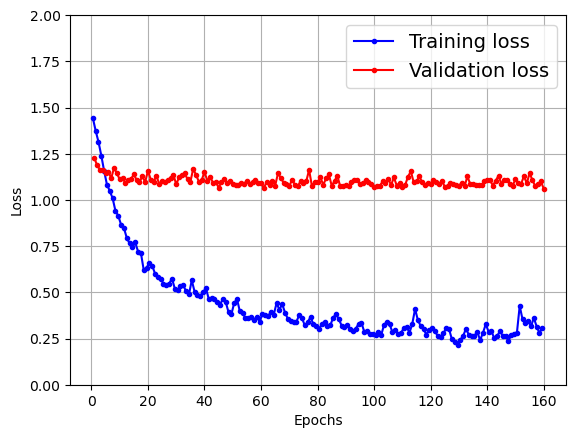

<Figure size 640x480 with 0 Axes>

In [37]:
print(history2.history["loss"])
plot_learning_curves(np.sqrt(history2.history["loss"]), np.sqrt(history2.history["val_loss"]))
plt.ylim(0,2)
plt.show()
#plt.savefig("deepfoodsecurity.png")

In [38]:
import skopt


param_distribs = {
    "n_hidden": [2,3, 4, 5, 6],
    "n_neurons": np.arange(10,100),
    "learning_rate": np.arange(0.0001, 0.003, 0.001),
}

bayes_search_cv = skopt.BayesSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
bayes_search_cv.fit(X_train2, y_train2, epochs=300,
                  validation_data=(X_test2, y_test2),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/300
15/15 [==============================] - 1s 10ms/step - loss: 2.1563 - val_loss: 1.5829
Epoch 2/300
15/15 [==============================] - 0s 3ms/step - loss: 2.0289 - val_loss: 1.5429
Epoch 3/300
15/15 [==============================] - 0s 3ms/step - loss: 1.9692 - val_loss: 1.5253
Epoch 4/300
15/15 [==============================] - 0s 3ms/step - loss: 1.8964 - val_loss: 1.5199
Epoch 5/300
15/15 [==============================] - 0s 3ms/step - loss: 1.8256 - val_loss: 1.5070
Epoch 6/300
15/15 [==============================] - 0s 3ms/step - loss: 1.6860 - val_loss: 1.5054
Epoch 7/300
15/15 [==============================] - 0s 3ms/step - loss: 1.5591 - val_loss: 1.5539
Epoch 8/300
15/15 [==============================] - 0s 3ms/step - loss: 1.4614 - val_loss: 1.4844
Epoch 9/300
15/15 [==============================] - 0s 3ms/step - loss: 1.2842 - val_loss: 1.4962
Epoch 10/300
15/15 [=============================

BayesSearchCV(cv=3,
              estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x00000273CDBF1340>,
              n_iter=10,
              search_spaces={'learning_rate': array([0.0001, 0.0011, 0.0021]),
                             'n_hidden': [2, 3, 4, 5, 6],
                             'n_neurons': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
       95, 96, 97, 98, 99])},
              verbose=2)

In [39]:
bayes_search_cv.best_params_

OrderedDict([('learning_rate', 0.0011), ('n_hidden', 4), ('n_neurons', 94)])

In [40]:
bayes_search_cv.best_score_

-1.4063807725906372

In [41]:
bayes_search_cv.score(X_test2, y_test2)

12/12 [==============================] - 0s 814us/step - loss: 1.2061


-1.2061419486999512

In [42]:
model = bayes_search_cv.best_estimator_.model
model.summary()

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_512 (Dense)           (None, 94)                6580      
                                                                 
 dense_513 (Dense)           (None, 94)                8930      
                                                                 
 dense_514 (Dense)           (None, 94)                8930      
                                                                 
 dense_515 (Dense)           (None, 94)                8930      
                                                                 
 dense_516 (Dense)           (None, 1)                 95        
                                                                 
Total params: 33,465
Trainable params: 33,465
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.evaluate(X_test2, y_test2)

12/12 [==============================] - 0s 859us/step - loss: 1.2061


1.2061419486999512

# ANN for Model 3

In [44]:
def build_model3(n_hidden=1, n_neurons=60, learning_rate=1e-3, input_shape=X_train3.shape[1]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [45]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model3)

C:\Users\stvp2\AppData\Local\Temp\ipykernel_2940\1370646454.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model3)


In [46]:
tf.random.set_seed(42)
# define the input shape and number of classes
input_shape = X_train3.shape[1]
num_classes = 1

# define the model architecture
model = keras.Sequential()
model.add(layers.Dense(70, activation='relu', input_shape=(input_shape,)))
for i in range(3):
    model.add(layers.Dense(70, activation='relu'))
model.add(layers.Dense(num_classes, activation='linear'))

optimizer = Adam(learning_rate=0.001)
# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)
#print(model.summary())
print(input_shape)

# train the model
history = model.fit(X_train3, y_train3, epochs=160, validation_data=(X_test3, y_test3))


69
Epoch 1/160
18/18 [==============================] - 0s 8ms/step - loss: 2.6591 - val_loss: 1.9881
Epoch 2/160
18/18 [==============================] - 0s 2ms/step - loss: 2.3857 - val_loss: 1.9270
Epoch 3/160
18/18 [==============================] - 0s 2ms/step - loss: 2.1537 - val_loss: 1.8873
Epoch 4/160
18/18 [==============================] - 0s 2ms/step - loss: 1.9047 - val_loss: 1.8717
Epoch 5/160
18/18 [==============================] - 0s 2ms/step - loss: 1.6956 - val_loss: 1.7687
Epoch 6/160
18/18 [==============================] - 0s 2ms/step - loss: 1.4892 - val_loss: 1.7228
Epoch 7/160
18/18 [==============================] - 0s 2ms/step - loss: 1.2786 - val_loss: 1.6742
Epoch 8/160
18/18 [==============================] - 0s 2ms/step - loss: 1.1007 - val_loss: 1.6014
Epoch 9/160
18/18 [==============================] - 0s 2ms/step - loss: 1.0224 - val_loss: 1.7223
Epoch 10/160
18/18 [==============================] - 0s 2ms/step - loss: 0.9012 - val_loss: 1.7327
Epoch 

[2.6590638160705566, 2.3857028484344482, 2.153658866882324, 1.9047346115112305, 1.6956048011779785, 1.4892066717147827, 1.2785617113113403, 1.1006510257720947, 1.0223662853240967, 0.9011593461036682, 0.8406015634536743, 0.8034873604774475, 0.8557878732681274, 0.7311902642250061, 0.670657217502594, 0.6745337843894958, 0.6812929511070251, 0.5969199538230896, 0.5670982599258423, 0.5600918531417847, 0.5138742923736572, 0.49683940410614014, 0.5483642220497131, 0.515095055103302, 0.4288164973258972, 0.42043694853782654, 0.4155559837818146, 0.3767501711845398, 0.4312555491924286, 0.3795539140701294, 0.42205724120140076, 0.3571602702140808, 0.333624929189682, 0.34971022605895996, 0.34154996275901794, 0.35907992720603943, 0.32064008712768555, 0.3350626528263092, 0.288891077041626, 0.27956467866897583, 0.29783162474632263, 0.2716990113258362, 0.30154484510421753, 0.2851720452308655, 0.2691831588745117, 0.2543932795524597, 0.2812919020652771, 0.2647929787635803, 0.23989079892635345, 0.25054791569

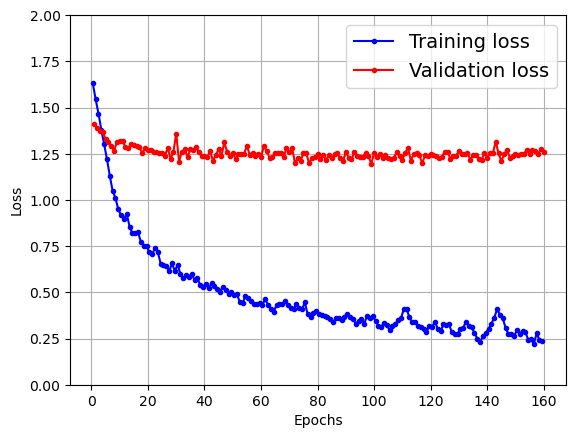

<Figure size 640x480 with 0 Axes>

In [47]:
print(history.history["loss"])
plot_learning_curves(np.sqrt(history.history["loss"]), np.sqrt(history.history["val_loss"]))
plt.ylim(0,2)
plt.show()
#plt.savefig("deepfoodsecurity.png")

In [48]:
import skopt


param_distribs = {
    "n_hidden": [2,3, 4, 5, 6],
    "n_neurons": np.arange(10,100),
    "learning_rate": np.arange(0.0001, 0.003, 0.001),
}

bayes_search_cv = skopt.BayesSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
bayes_search_cv.fit(X_train3, y_train3, epochs=300,
                  validation_data=(X_test3, y_test3),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/300
12/12 [==============================] - 1s 13ms/step - loss: 2.7086 - val_loss: 2.1044
Epoch 2/300
12/12 [==============================] - 0s 3ms/step - loss: 2.6378 - val_loss: 2.0619
Epoch 3/300
12/12 [==============================] - 0s 3ms/step - loss: 2.5903 - val_loss: 2.0240
Epoch 4/300
12/12 [==============================] - 0s 3ms/step - loss: 2.5297 - val_loss: 1.9896
Epoch 5/300
12/12 [==============================] - 0s 3ms/step - loss: 2.4828 - val_loss: 1.9630
Epoch 6/300
12/12 [==============================] - 0s 3ms/step - loss: 2.4119 - val_loss: 1.9331
Epoch 7/300
12/12 [==============================] - 0s 3ms/step - loss: 2.3385 - val_loss: 1.8898
Epoch 8/300
12/12 [==============================] - 0s 3ms/step - loss: 2.2275 - val_loss: 1.8421
Epoch 9/300
12/12 [==============================] - 0s 3ms/step - loss: 2.1018 - val_loss: 1.8053
Epoch 10/300
12/12 [=============================

BayesSearchCV(cv=3,
              estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x00000273DFE71160>,
              n_iter=10,
              search_spaces={'learning_rate': array([0.0001, 0.0011, 0.0021]),
                             'n_hidden': [2, 3, 4, 5, 6],
                             'n_neurons': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
       95, 96, 97, 98, 99])},
              verbose=2)

In [49]:
bayes_search_cv.best_params_

OrderedDict([('learning_rate', 0.0011), ('n_hidden', 4), ('n_neurons', 87)])

In [50]:
bayes_search_cv.best_score_

-1.7787501017252605

In [51]:
bayes_search_cv.score(X_test3, y_test3)

9/9 [==============================] - 0s 933us/step - loss: 1.4604


-1.4603556394577026

In [52]:
model = bayes_search_cv.best_estimator_.model
model.summary()

Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_684 (Dense)           (None, 87)                6090      
                                                                 
 dense_685 (Dense)           (None, 87)                7656      
                                                                 
 dense_686 (Dense)           (None, 87)                7656      
                                                                 
 dense_687 (Dense)           (None, 87)                7656      
                                                                 
 dense_688 (Dense)           (None, 1)                 88        
                                                                 
Total params: 29,146
Trainable params: 29,146
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.evaluate(X_test3, y_test3)

9/9 [==============================] - 0s 868us/step - loss: 1.4604


1.4603556394577026

In [55]:
np.sqrt(1.5)

1.224744871391589